# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

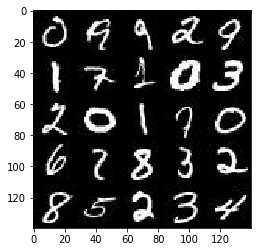

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

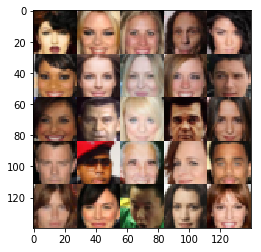

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=None)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [4]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3(or 1)
        x1 = tf.layers.conv2d(images, 128, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 28x28x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3(or 1) now
        
        out = tf.tanh(logits) * 0.5
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [6]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [9]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    num_channels = 3 if data_image_mode=='RGB' else 1
    
    _, image_width, image_height, image_channels = data_shape
    
    pl_input_real, pl_input_z, pl_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(pl_input_real, pl_input_z, num_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, pl_learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    show_n_images = 25
    
    sample_z = np.random.uniform(-1, 1, size=(show_n_images, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={pl_input_real: batch_images, pl_input_z: batch_z, pl_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={pl_input_real: batch_images, pl_input_z: batch_z, pl_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={pl_input_real: batch_images, pl_input_z: batch_z, pl_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({pl_input_z: batch_z, pl_input_real: batch_images})
                    train_loss_g = g_loss.eval({pl_input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, pl_input_z, num_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 5.4522
Epoch 1/2... Discriminator Loss: 3.1158... Generator Loss: 3.6839
Epoch 1/2... Discriminator Loss: 2.7435... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 2.1388... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 1.6401... Generator Loss: 1.2800
Epoch 1/2... Discriminator Loss: 1.7230... Generator Loss: 1.3490
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 1.4489
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.8380


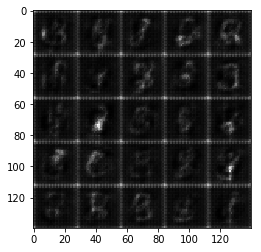

Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.3179
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.3683
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.2363
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.4816
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 1.8529
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.3184


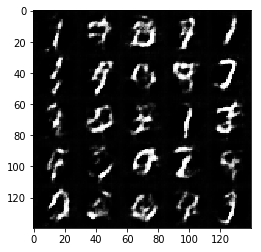

Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 2.3417
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.8767


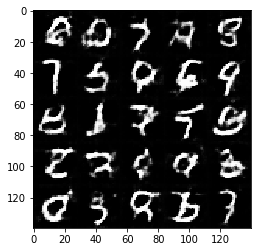

Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.8353... Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 2.1570... Generator Loss: 0.1768
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 2.8671... Generator Loss: 3.2820
Epoch 1/2... Discriminator Loss: 1.7373... Generator Loss: 0.3235
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.7753


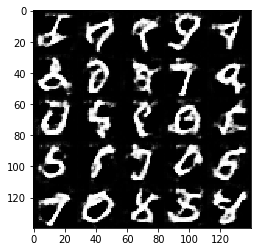

Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.3578
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.5151
Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 0.2869
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.4863
Epoch 2/2... Discriminator Loss: 1.8853... Generator Loss: 2.5887
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 1.3020


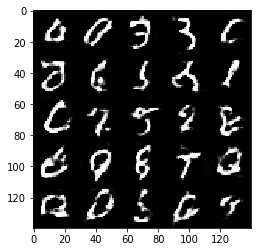

Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.5709
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 1.3870
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.5969
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 1.1014


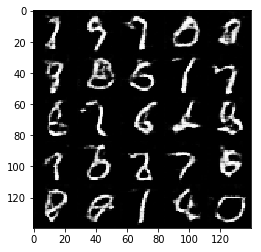

Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.3948
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 0.9540... Generator Loss: 1.0833
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.5676
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.5865
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.9457


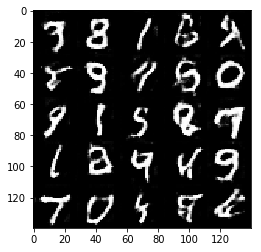

Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 1.6447
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 1.2020
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.7813... Generator Loss: 0.2361
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 1.9164... Generator Loss: 0.2058
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.4438
Epoch 2/2... Discriminator Loss: 2.0399... Generator Loss: 0.1934


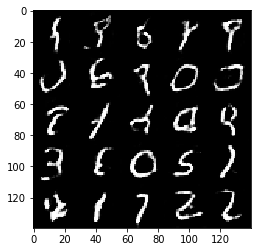

Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.4957
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.3986
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.0684
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 2.2869... Generator Loss: 0.1355
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.6880


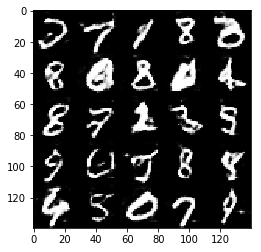

Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.5388


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.3014... Generator Loss: 0.0098
Epoch 1/1... Discriminator Loss: 4.7673... Generator Loss: 0.0499
Epoch 1/1... Discriminator Loss: 2.2585... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.8075... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.6417


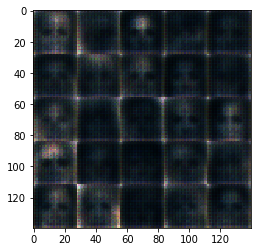

Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.7806... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.8142... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 2.0756... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.7246... Generator Loss: 0.5885


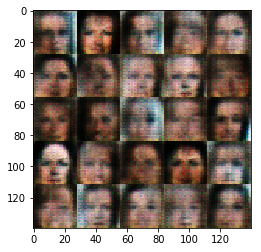

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.7085... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 2.1659... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.8979... Generator Loss: 0.4900


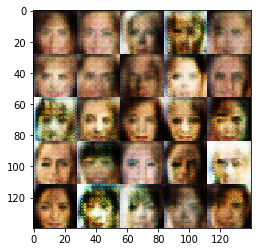

Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.6899


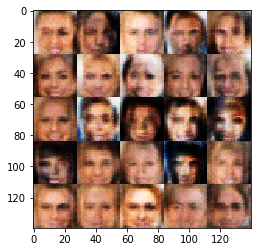

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7102


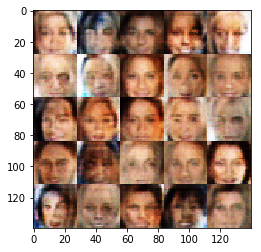

Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.6205


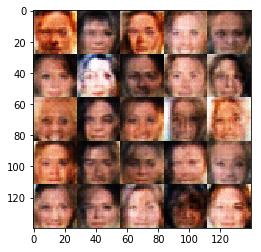

Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.6528


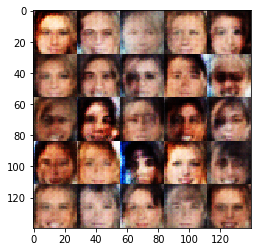

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5908


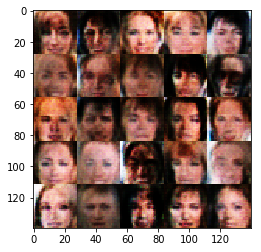

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.